# Blade Beam Calculator for single case

José Alberto Navarro Martínez (s175511@student.dtu.dk), July 2019

Modified by Lars P. Mikkelsen, January 2020

This code has been developed as part of the final project "Material choice and blade design", for the Wind Energy Master at Technical University of Denmark (DTU).

Given a set of material(s) and blade length(s), it calculates the optimised blade mass, blade tip deflection, cost, embodied energy and CO2 production.

In [1]:
# Import needed Python libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import Blade_Calculator_Functions as BCF

## Blade length

In [2]:
length=100

## Material Input

In [3]:
# GFRP
E = 37.9e9 # [Pa]  
Strength = 140e6 # [Pa]  (strength is here defined as the acceptable fatigue stress level)
rho = 1850.0 # [kg/m^3]
#
price = 3.97 # [USD/kg]
EE = 112.5 # [MJ/kg]
CO2_footprint = 7.9 # [kgCO2/kg]

In [4]:
# CFRP
#E = 142e9 # [Pa]
#Strength = 350e6 # [Pa]
#rho = 1580.0 # [kg/m^3]
#
#price = 17.64 # [USD/kg]
#EE = 272.5 # [MJ/kg]
#CO2_footprint = 17.2 # [kgCO2/kg]

In [5]:
# Bamboo
#E = 21.6e9 # [Pa]
#Strength = 101e6 # [Pa]
#rho = 1000.0 # [kg/m3]
#
#price = 1.10 # [USD/kg]
#EE = 5 # [MJ/kg]
#CO2_footprint = 1.13 # [kgCO2/kg]

## Blade dimensions
Dimensions normalised (non-dimensional) blade geometry from DTU 10MW RWT blade

Text(0.5, 1.0, 'Normalized blade geometry')

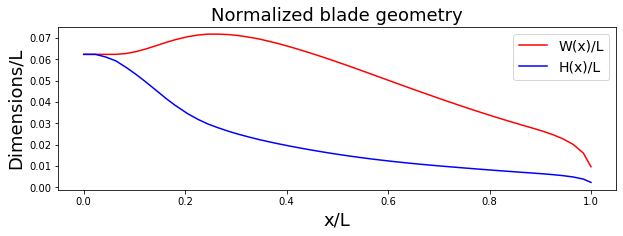

In [6]:
DataFile='blade_geo_adim.csv'
x_adim,h_edge_adim,h_flap_adim = np.loadtxt(open(DataFile,'r'),skiprows=2,
delimiter=';',usecols=(0,1,2),dtype=float,unpack=True)
# Plot normalized blade dimensions:
plt.figure(figsize=(10,3))
plt.plot(x_adim,h_edge_adim,'-r',label='W(x)/L')
plt.plot(x_adim,h_flap_adim,'-b',label='H(x)/L')
plt.xlabel(r'x/L',fontsize=18)
plt.ylabel(r'Dimensions/L',fontsize=18)
plt.legend(loc=0,fontsize=14)
StrTitle = 'Normalized blade geometry'
plt.title(StrTitle,fontsize=18)

## Calculate geometry of specific blade

Text(0.5, 1.0, 'Blade geometry for L = 100 m')

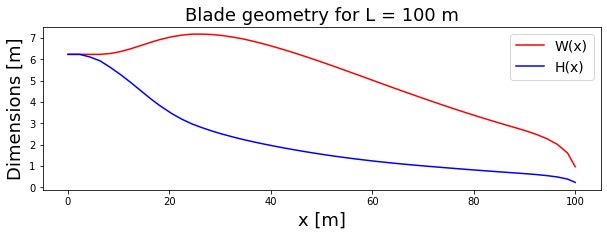

In [7]:
L = length # Blade length [m]
x = x_adim * L
h_edge = h_edge_adim * L
h_flap = h_flap_adim * L
N = len(x) # Number of coordinates
# Plot physical blade dimensions:
plt.figure(figsize=(10,3))
plt.plot(x,h_edge,'-r',label='W(x)')
plt.plot(x,h_flap,'-b',label='H(x)')
plt.xlabel(r'x [m]',fontsize=18)
plt.ylabel(r'Dimensions [m]',fontsize=18)
plt.legend(loc=0,fontsize=14)
StrTitle = 'Blade geometry for L = ' + str(L) + ' m'
plt.title(StrTitle,fontsize=18)

## Calculate some blade parameters
In the following is used emperical relations between
 * Roter radius version blade length: R = L + (0.0277*L-0.277)
 * Generator size: Pmax = 1000*(2*R)**1.789
 * Tower Clearance: clearance = 0.201*L+0.2259
 * Deflection limit: defl_limit = 0.7*clearance
 
If wanted, each of those values can be replace by specific values

In [8]:
g = 9.81 # Gravitational acceleration [m/s^2]
rho_air = 1.225 # Density of air [kg/m^3]
R = L + (0.0277*L-0.277) # Rotor radius [m]
Pmax = 1000*(2*R)**1.789 # Nominal power [W]
At = np.pi*(R**2) # Swept area [m^2]
uR = (27*Pmax/(8*rho_air*At))**(1/3)  # Rated wind speed [m/s]
clearance = 0.201*L+0.2259 # Tower clearance [m]
defl_limit = 0.7*clearance # Maximum allowable tip deflection [m]

## Fatigue Design (FD)
Distribute the material such that the strength (Fatigue Design) is satisfied in all the flapwise material using the following relations

Text(0.5, 1.0, 'Fatigue Design')

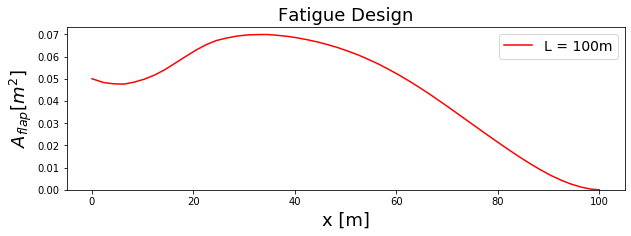

In [9]:
A_flap_FD = 8/81*rho_air*uR**2*np.pi*R**2*L/(Strength*h_flap)*(1+x/(2*L))*(1-x/L)**2 
# Plot solution:
plt.figure(figsize=(10,3))
plt.plot(x,A_flap_FD,'-r',label='L = '+np.str(L)+'m')
plt.xlabel(r'x [m]',fontsize=18)
plt.ylabel(r'$A_{flap} [m^2]$',fontsize=18)
plt.legend(loc=0,fontsize=14)
StrTitle = 'Fatigue Design'
plt.ylim(bottom=0)
plt.title(StrTitle,fontsize=18)

## Calculate edge properties for Fatigue Design (FD)

In [10]:
A_flap = A_flap_FD
sigma0=Strength

In [11]:
wmax_flap = BCF.tipdisp(A_flap,rho_air,uR,x,L,E,h_flap,R) # Blade tip disp [m]

# Optimisation of edge area

# Constraint: sigma_edge = sigma0
def constraintFD(A_edge,A_flap,rho,g,x,sigma0,h_edge):
    return sigma0*A_edge*h_edge-BCF.Medge(A_flap,A_edge,rho,g,x)
conFD = {'type': 'eq', 'fun': constraintFD, 'args': (A_flap,rho,g,x,sigma0,h_edge) }

# Initial guess (corresponds to FD when A_blade = cte.)
A_edge0 = rho*g*L**2*A_flap*(1-x/L)**2/(sigma0*h_edge-rho*g*L**2*(1-x/L)**2)

opt = {'maxiter': 10000, 'disp': True}
sol_Aedge = minimize(BCF.mass,A_edge0,args=(A_flap,rho,x),method='SLSQP',jac=BCF.mass_jacob,
                         constraints=conFD,options=opt)
A_edge_FD = sol_Aedge.x
A_edge = A_edge_FD

M = BCF.mass(A_flap,A_edge,rho,x) # Blade mass [tonnes]

C:\Users\lapm\HCP\11MSc\21-MathiasBach\BladeCalculator\NewVersionV2\Blade_Calculator_Functions.py:212: RuntimeWarning: invalid value encountered in double_scalars
  Thx_flap[i] = Thx_flap[i-1] + 0.5*(Mx_flap[i]/EIx_flap[i] + Mx_flap[i-1]/EIx_flap[i-1])*(x[i]-x[i-1])


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.54295689324332
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2


wmax_flap_FD =  17.068002922016717  m
MaxDefl      =  14.22813  m
Total mass of blade: MFD =  17.54295689324332  tonnes


Text(0.5, 1.0, 'Fatigue Design')

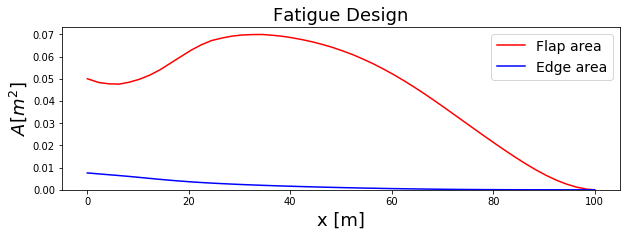

In [12]:
wmax_flap_FD=wmax_flap
A_edge_FD=A_edge
MFD=M
print('wmax_flap_FD = ',wmax_flap_FD,' m')
print('MaxDefl      = ',defl_limit,' m' )
print('Total mass of blade: MFD = ',MFD,' tonnes')
# Plot solution:
plt.figure(figsize=(10,3))
plt.plot(x,A_flap_FD,'-r',label='Flap area')
plt.plot(x,A_edge_FD,'-b',label='Edge area')
plt.xlabel(r'x [m]',fontsize=18)
plt.ylabel(r'$A [m^2]$',fontsize=18)
plt.legend(loc=0,fontsize=14)
StrTitle = 'Fatigue Design'
plt.ylim(bottom=0)
plt.title(StrTitle,fontsize=18)

## Deflection Design (DD)
Check for fullfill of tower clearance and if not calculate the Deflection Design (DD). This is done using an optimization algorithme by added as little material as possible lowering the deflection just below the deflection limit. 

In [13]:
print('wmax_flap_FD = ',wmax_flap_FD,' m')
print('MaxDefl      = ',defl_limit,' m' )

wmax_flap_FD =  17.068002922016717  m
MaxDefl      =  14.22813  m


In [14]:
if wmax_flap_FD > defl_limit: # Flap area corresponding to Fatigue Design (FD)
    # First optimisation:
    # A_flap that fulfils tip deflection requirement and gives minimum flap mass

    # Create boundary: lower limit = A_flap_FD
    bnds = []
    for i in range(0,N):
        bnds.append((A_flap_FD[i],np.inf))

    # Constraint: wmax = defl_limit
    def constraintDD1(A_flap,rho_air,uR,x,L,E,h_flap,defl_limit,R):
        return defl_limit - BCF.tipdisp(A_flap,rho_air,uR,x,L,E,h_flap,R)

    conDD1 = {'type': 'eq', 'fun': constraintDD1, 'args': (rho_air,uR,x,L,E,h_flap,defl_limit,R) }

    # Initial guess
    A_flap0 = A_flap_FD

    opt = {'maxiter': 10000, 'disp': True}
    sol_Aflap = minimize(BCF.flapmass,A_flap0,args=(rho,x),method='SLSQP',jac=BCF.flapmass_jacob,
                         constraints=conDD1,bounds=bnds,options=opt,tol=1e-3)
    A_flap = sol_Aflap.x

    # Second optimisation
    # Once A_flap has been obtained, look for A_edge that fulfils sigma_edge = sigma0

    # Constraint: sigma_edge = sigma0
    def constraintDD2(A_edge,A_flap,rho,g,x,sigma0,h_edge):
        return sigma0*A_edge*h_edge-BCF.Medge(A_flap,A_edge,rho,g,x)

    conDD2 = {'type': 'eq', 'fun': constraintDD2, 'args': (A_flap,rho,g,x,sigma0,h_edge) }

    # Initial guess (correspond to FD when A_blade = cte.)
    A_edge0 = rho*g*L**2*A_flap*(1-x/L)**2/(sigma0*h_edge-rho*g*L**2*(1-x/L)**2)

    sol_Aedge = minimize(BCF.mass,A_edge0,args=(A_flap,rho,x),method='SLSQP',jac=BCF.mass_jacob,
                         constraints=conDD2,options=opt)
    A_edge = sol_Aedge.x

    wmax_flap = BCF.tipdisp(A_flap,rho_air,uR,x,L,E,h_flap,R) # Blade tip disp [m]
    M = BCF.mass(A_flap,A_edge,rho,x) # Blade mass [tonnes]


C:\Users\lapm\HCP\11MSc\21-MathiasBach\BladeCalculator\NewVersionV2\Blade_Calculator_Functions.py:212: RuntimeWarning: invalid value encountered in double_scalars
  Thx_flap[i] = Thx_flap[i-1] + 0.5*(Mx_flap[i]/EIx_flap[i] + Mx_flap[i-1]/EIx_flap[i-1])*(x[i]-x[i-1])


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 20.344023612989282
            Iterations: 122
            Function evaluations: 413
            Gradient evaluations: 122
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 21.43334409531915
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2


wmax_flap_DD =  14.22909974785169  m
MaxDefl         =  14.22813  m
MFD =  17.54295689324332  tonnes
MDD =  21.43334409531915  tonnes


Text(0.5, 1.0, 'Compare Fatigue Design and Deflection design')

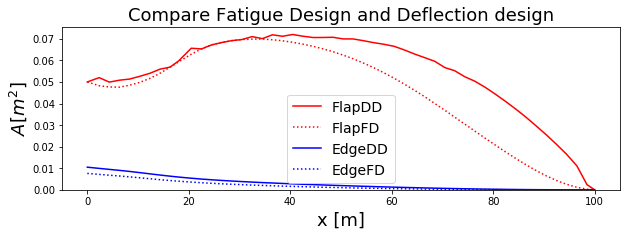

In [15]:
if wmax_flap_FD > defl_limit: # Flap area corresponding to Fatigue Design (FD)
    wmax_flap_DD=wmax_flap
    A_edge_DD=A_edge
    A_flap_DD=A_flap
    MDD=M
else:
    wmax_flap_DD=wmax_flap_FD
    A_edge_DD=A_edge_FD
    A_flap_DD=A_flap_FD
    MDD=MFD

print('wmax_flap_DD = ',wmax_flap_DD,' m')
print('MaxDefl         = ',defl_limit,' m' )
print('MFD = ',MFD,' tonnes')
print('MDD = ',MDD,' tonnes')
# Plot solution:
plt.figure(figsize=(10,3))
plt.plot(x,A_flap_DD,'-r',label='FlapDD')
plt.plot(x,A_flap_FD,':r',label='FlapFD')
plt.plot(x,A_edge_DD,'-b',label='EdgeDD')
plt.plot(x,A_edge_FD,':b',label='EdgeFD')
plt.xlabel(r'x [m]',fontsize=18)
plt.ylabel(r'$A [m^2]$',fontsize=18)
plt.legend(loc=0,fontsize=14)
StrTitle = 'Compare Fatigue Design and Deflection design'
plt.ylim(bottom=0)
plt.title(StrTitle,fontsize=18)

## Summary of results

In [16]:
M=MDD
cost = M*price # Blade cost [kUSD]
cost_area = 3*cost*1000/(np.pi*R**2) # Rotor cost per swept area [USD/m^2]
EEb = M*1000*EE # Embodied energy [MJ]
CO2prod = M*CO2_footprint # CO2 footprint [CO2 tonnes]
sigmaflap = BCF.sigma_flap(A_flap,rho_air,uR,x,L,h_flap,R)/1e6 # Flapwise stress [MPa]
s0 = Strength*np.ones(N)/1e6 # Fatigue strength [MPa]

C:\Users\lapm\HCP\11MSc\21-MathiasBach\BladeCalculator\NewVersionV2\Blade_Calculator_Functions.py:177: RuntimeWarning: invalid value encountered in true_divide
  sigma_flap = Mx_flap/(A_flap*h_flap)


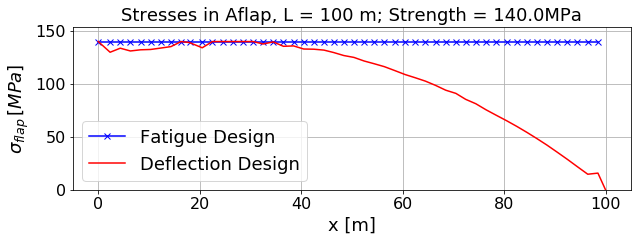

In [17]:
# Plot FD and DD flap-wise stresses
sflap_FD = BCF.sigma_flap(A_flap_FD,rho_air,uR,x,L,h_flap,R)/1e6 # [MPa]
sflap_DD = BCF.sigma_flap(A_flap_DD,rho_air,uR,x,L,h_flap,R)/1e6 # [MPa]

plt.figure(figsize=(10,3))
plt.tick_params(labelsize=16)
plt.plot(x,sflap_FD,'bx-',label=r'Fatigue Design')
plt.plot(x,sflap_DD,'r-',label=r'Deflection Design')
plt.ylabel(r'$\sigma_{flap}\,[MPa]$',fontsize=18)
plt.xlabel(r'x [m]',fontsize=18)
plt.ylim(0,Strength*1.1e-6)
title = 'Stresses in Aflap, L = ' + str(L) + ' m'+'; Strength = '+str(Strength/1e6)+'MPa'
plt.title(title,fontsize=18)
plt.grid()
plt.legend(loc='best',fontsize=18)
plt.show()

In [18]:
print('Results for L = %.2f m' % L)
print('=======================')
print('')
print('Blade mass [tonnes]: ',MDD)
print('Blade cost [k$]: ',cost)
print('Rotor cost per swept area [$/m^2]: ', cost_area)
print('Blade tip deflection [m]: ',wmax_flap_DD)
print('Embodied energy [MJ]: ', EEb)
print('CO2 production [CO2 tonnes]: ',CO2prod)


Results for L = 100.00 m

Blade mass [tonnes]:  21.43334409531915
Blade cost [k$]:  85.09037605841704
Rotor cost per swept area [$/m^2]:  7.735055151038292
Blade tip deflection [m]:  14.22909974785169
Embodied energy [MJ]:  2411251.2107234043
CO2 production [CO2 tonnes]:  169.32341835302128
